<a href="https://colab.research.google.com/github/dhcryan/dm_project/blob/main/dm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn import metrics
from sklearn.cluster import *
from scipy.spatial.distance import cdist

In [2]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 45 kB/s 
     |████████████████████████████████| 199 kB 45.3 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=2da2bd9fc9d37dd085d5aab6e3696ac8b160a210d375c33a4c8e0104eb3db078
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upg

In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import re
import sys
import itertools as it
from pyspark import SparkConf, SparkContext

In [6]:
import pyspark
from pyspark.sql import SQLContext

In [7]:
file_path='/content/drive/MyDrive'
fifa_path='/players_fifa23.csv'

import pyspark 
from pyspark.sql import SparkSession 


In [8]:
spark=SparkSession.builder.appName('fifa').getOrCreate()

In [9]:
# # File location and type
# file_location = "/content/drive/MyDrive/players_fifa23.csv"
# file_type = "csv"

# # CSV options
# infer_schema = "true"
# first_row_is_header = "true"
# delimiter = ","

# # The applied options are for CSV files. For other file types, these will be ignored.
# df = spark.read.format(file_type) \
#   .option("inferSchema", infer_schema) \
#   .option("header", first_row_is_header) \
#   .option("sep", delimiter) \
#   .load(file_location)

# df.show(10)

In [10]:
# # The applied options are for CSV files. For other file types, these will be ignored.
df=spark.read.option("inferSchema", "true").option("header", "true").csv('/content/drive/MyDrive/players_fifa23.csv')
df.show(10) 

+--------+-----------------------+------------------------------------+----+-------+-------+-------------------------------------------------+-------------------------+--------+----------+-------+-----------+----------+--------------+-------------+--------------------------------------+----------+--------+--------------+-------------+--------------+-----------+-----------+-------+--------------------+-----------------+---------------+--------------+--------------+---------+-----------+------------------+------------------+----------+--------------+-------------+---------------+---------------+-----------------+---------+----------+----------------+-------------+--------+----------+------+-----------+------------+------------+-------------+------------+--------+----------+--------+----------+--------+--------+---------+----------+-----------+--------------+------------+-------+----------+----------+--------+---------------+--------------+---------+-----------+----------+--------------+-

In [11]:
from pyspark.sql.functions import trim
#strip header space
for each in df.schema.names:
    df = df.withColumnRenamed(each,re.sub(r'\s+([a-zA-Z_][a-zA-Z_0-9]*)\s*','',each.replace(' ', '')))
df.show(10)

+--------+--------------------+--------------------+----+------+------+--------------------+--------------------+-------+---------+------+----------+---------+--------------+-------------+--------------------+--------+--------+-------------+-------------+--------------+-----------+----------+-------+--------------------+-----------------+---------------+--------------+-------------+--------+----------+------------------+------------------+---------+-------------+------------+--------------+--------------+----------------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+--------+--------+--------+--------+--------+--------+---------+--------+--------+--------+---------+---------+---

In [12]:
from pyspark.sql.functions import *

for c_name in df.columns:
    if c_name in ['PhotoUrl','Nationality','Positions','BestPosition','ClubPosition','ContractUntil','ClubNumber','OnLoad','NationalTeam','NationalPosition','NationalNumber','PreferredFoot','AttackingWorkRate','DefensiveWorkRate']:
      df = df.withColumn(c_name, trim(col(c_name)))
df.show()

+--------+--------------------+--------------------+----+------+------+--------------------+--------------+-------+---------+------+----------+---------+---------+------------+--------------------+--------+--------+-------------+------------+-------------+----------+----------+------+------------+----------------+--------------+-------------+-------------+--------+----------+-----------------+-----------------+---------+-------------+------------+--------------+--------------+----------------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+--------+--------+--------+--------+--------+--------+---------+--------+--------+--------+---------+---------+---------+--------+--------+----

### missing value analysis


In [13]:
# Find count for empty, None, Null, Nan with string literals.
from pyspark.sql.functions import col,isnan,when,count
missing_df = df.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c 
                           )).alias(c)
                    for c in df.columns])
missing_df.show()

# ClubPosition|ContractUntil|ClubNumber 92개의 missing value
# NationalPosition|NationalNumber -> 국대 아닌 선수들 17722
# 그 외의 결측치 없음

+---+----+--------+---+------+------+--------+-----------+-------+---------+------+----------+---------+---------+------------+----+--------+-------+-------------+------------+-------------+----------+----------+------+------------+----------------+--------------+-------------+-------------+--------+----------+-----------------+-----------------+---------+-------------+------------+--------------+--------------+----------------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+--------+--------+--------+--------+--------+--------+---------+--------+--------+--------+---------+---------+---------+--------+--------+--------+--------+
| ID|Name|FullName|Age|Height|Weight|PhotoUrl|Natio

In [14]:
df.printSchema()

root
 |-- ID: double (nullable = true)
 |-- Name: string (nullable = true)
 |-- FullName: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Height: double (nullable = true)
 |-- Weight: double (nullable = true)
 |-- PhotoUrl: string (nullable = true)
 |-- Nationality: string (nullable = true)
 |-- Overall: double (nullable = true)
 |-- Potential: double (nullable = true)
 |-- Growth: double (nullable = true)
 |-- TotalStats: double (nullable = true)
 |-- BaseStats: double (nullable = true)
 |-- Positions: string (nullable = true)
 |-- BestPosition: string (nullable = true)
 |-- Club: string (nullable = true)
 |-- ValueEUR: double (nullable = true)
 |-- WageEUR: double (nullable = true)
 |-- ReleaseClause: double (nullable = true)
 |-- ClubPosition: string (nullable = true)
 |-- ContractUntil: string (nullable = true)
 |-- ClubNumber: string (nullable = true)
 |-- ClubJoined: double (nullable = true)
 |-- OnLoad: string (nullable = true)
 |-- NationalTeam: string (nullabl

In [15]:
from pyspark.sql.types import IntegerType
df=df.withColumn("ID",df["ID"].cast(IntegerType()))
df=df.withColumn("Age",df["Age"].cast(IntegerType()))
df=df.withColumn("Overall",df["Overall"].cast(IntegerType()))
df=df.withColumn("Potential",df["Potential"].cast(IntegerType()))
df=df.withColumn("IntReputation",df["IntReputation"].cast(IntegerType()))
df=df.withColumn("SkillMoves",df["SkillMoves"].cast(IntegerType()))
df=df.withColumn("WeakFoot",df["WeakFoot"].cast(IntegerType()))
df=df.withColumn("Height",df["Height"].cast(IntegerType()))
df=df.withColumn("Weight",df["Weight"].cast(IntegerType()))


In [16]:
df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- FullName: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Height: integer (nullable = true)
 |-- Weight: integer (nullable = true)
 |-- PhotoUrl: string (nullable = true)
 |-- Nationality: string (nullable = true)
 |-- Overall: integer (nullable = true)
 |-- Potential: integer (nullable = true)
 |-- Growth: double (nullable = true)
 |-- TotalStats: double (nullable = true)
 |-- BaseStats: double (nullable = true)
 |-- Positions: string (nullable = true)
 |-- BestPosition: string (nullable = true)
 |-- Club: string (nullable = true)
 |-- ValueEUR: double (nullable = true)
 |-- WageEUR: double (nullable = true)
 |-- ReleaseClause: double (nullable = true)
 |-- ClubPosition: string (nullable = true)
 |-- ContractUntil: string (nullable = true)
 |-- ClubNumber: string (nullable = true)
 |-- ClubJoined: double (nullable = true)
 |-- OnLoad: string (nullable = true)
 |-- NationalTeam: string (n

### attribute 분류

In [17]:
print(df.show())

+------+--------------------+--------------------+---+------+------+--------------------+--------------+-------+---------+------+----------+---------+---------+------------+--------------------+--------+--------+-------------+------------+-------------+----------+----------+------+------------+----------------+--------------+-------------+-------------+--------+----------+-----------------+-----------------+---------+-------------+------------+--------------+--------------+----------------+--------+---------+---------------+------------+-------+---------+-----+----------+-----------+-----------+------------+-----------+-------+---------+-------+---------+-------+-------+--------+---------+----------+-------------+-----------+------+---------+---------+-------+--------------+-------------+--------+----------+---------+-------------+----------+--------+--------+--------+--------+--------+--------+---------+--------+--------+--------+---------+---------+---------+--------+--------+-------

In [18]:
Fifa_df = df.toPandas()
print(Fifa_df)

           ID                     Name                              FullName  \
0      158023  L. Messi                 Lionel Messi                           
1      165153  K. Benzema               Karim Benzema                          
2      188545  R. Lewandowski           Robert Lewandowski                     
3      192985  K. De Bruyne             Kevin De Bruyne                        
4      231747  K. Mbappé                Kylian Mbappé                          
...       ...                      ...                                   ...   
18534  243725  D. Collins               Darren Collins                         
18535  261933  Yang Dejiang             Dejiang Yang                           
18536  267823  L. Mullan                Liam Mullan                            
18537  267824  D. McCallion             Daithí McCallion                       
18538  261424  N. Rabha                 Nabin Rabha                            

       Age  Height  Weight             

In [19]:
Fifa_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18539 entries, 0 to 18538
Data columns (total 90 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 18539 non-null  int32  
 1   Name               18539 non-null  object 
 2   FullName           18539 non-null  object 
 3   Age                18539 non-null  int32  
 4   Height             18539 non-null  int32  
 5   Weight             18539 non-null  int32  
 6   PhotoUrl           18539 non-null  object 
 7   Nationality        18539 non-null  object 
 8   Overall            18539 non-null  int32  
 9   Potential          18539 non-null  int32  
 10  Growth             18539 non-null  float64
 11  TotalStats         18539 non-null  float64
 12  BaseStats          18539 non-null  float64
 13  Positions          18539 non-null  object 
 14  BestPosition       18539 non-null  object 
 15  Club               18539 non-null  object 
 16  ValueEUR           185

## Clustering


In [102]:
#gk와 non gk구분 
def segment_gk(Fifa_df):
  gk_data=Fifa_df[Fifa_df.BestPosition=='GK']
  nongk_data=Fifa_df[Fifa_df.BestPosition!='GK']
  return gk_data,nongk_data
  

In [103]:
gk,non_gk=segment_gk(Fifa_df)


In [121]:
# attrs=['Crossing','Finishing','HeadingAccuracy','ShortPassing','Volleys','Dribbling','Curve'\
#        ,'FKAccuracy','LongPassing','BallControl','Acceleration','SprintSpeed','Agility','Reactions'\
#        ,'Balance','ShotPower','Jumping','Stamina','Strength','LongShots','Aggression','Interceptions'\
#        ,'Positioning','Vision','Penalties','Composure','Marking','StandingTackle','SlidingTackle'\
#        ,'GKDiving','GKHandling','GKKicking','GKPositioning','GKReflexes']
def cluster_attrs(nongk):    
    attrs_groups = dict()
    attrs_groups['passing'] = ['Crossing','ShortPassing','FKAccuracy','LongPassing','Vision']
    attrs_groups['shooting'] = ['Finishing','LongShots','Penalties','ShotPower','Volleys','Curve']
    attrs_groups['pace'] = ['Acceleration','SprintSpeed']
    attrs_groups['skill'] = ['BallControl','Dribbling']
    attrs_groups['movement']=['Agility','Reactions','Positioning','Composure']
    attrs_groups['defending'] = ['Interceptions','Marking','StandingTackle','SlidingTackle']
    attrs_groups['pysicality'] = ['Aggression','Stamina','Strength','Balance','Jumping','HeadingAccuracy']
    #attrs_groups['goalkeeping'] = ['GKDiving', 'GKHandling','GKKicking', 'GKPositioning', 'GKReflexes']
    pass_index=nongk[attrs_groups['passing']].mean(axis=1)
    shoot_index=nongk[attrs_groups['shooting']].mean(axis=1)
    pace_index=nongk[attrs_groups['pace']].mean(axis=1)
    skill_index=nongk[attrs_groups['skill']].mean(axis=1)
    movement_index=nongk[attrs_groups['movement']].mean(axis=1)
    defense_index=nongk[attrs_groups['defending']].mean(axis=1)
    pysical_index=nongk[attrs_groups['pysicality']].mean(axis=1)
    
    index_concat=pd.concat([pass_index,shoot_index,pace_index,skill_index,movement_index,defense_index,pysical_index],axis=1,ignore_index=True)
    #radar chart만들기 위해 normalize해야 할 필요성 있음 min-max normalization
    nongk_value = index_concat.values #returns a numpy array
    scaler = preprocessing.StandardScaler()
    nongk_scaled=scaler.fit_transform(nongk_value)
    return nongk_scaled.round(2)

In [122]:
nongk_scaled=cluster_attrs(non_gk)
nongk_df= pd.DataFrame(nongk_scaled)
nongk_df.columns=['pass_index','shoot_index','pace_index','skill_index','movement_index','defense_index','pysical_index']

After fitting a PCA object to the standardized matrix, we can see how much of the variance is explained by each of the nine features.

In [123]:
from sklearn.decomposition import PCA
pca=PCA()
pca.fit(nongk_scaled)
evr = pca.explained_variance_ratio_
print(evr)

[0.53406225 0.2333198  0.10916886 0.07671527 0.02135    0.01443702
 0.01094679]


In general, it is a good rule of thumb to preserve around 80% of the variance. Therefore, in this instance, we can select the 3 most important principal components to incorporate in the k-means algorithm.

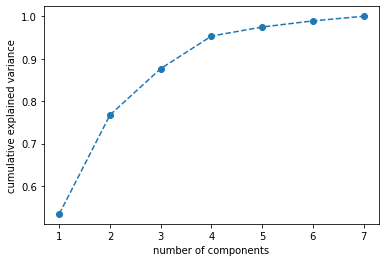

In [126]:
plt.plot(range(1,len(nongk_df.columns)+1),np.cumsum(evr),marker='o',linestyle='--')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

This can be accomplished by instantiating a new PCA object with the n_components parameter set to 3.

In [127]:
for i, exp_var in enumerate(evr.cumsum()):
    if exp_var >= 0.8:
        n_comps = i + 1
        break
print("Number of components:", n_comps)
pca = PCA(n_components=n_comps)
pca.fit(nongk_scaled)
nongk_scaled_pca = pca.transform(nongk_scaled)

Number of components: 3


### Elbow Method for optimal value of k in KMeans

In [106]:
# Cluster 간의 거리의 합을 나타내는 inertia가 급격히 떨어지는 구간이 생기는데
# 이 지점의 K 값을 군집의 개수로 사용
# inertia_속성으로 확인할 수 있다.
# 클러스터 간 거리의 합을 나타내는 inertia value가 급격히 떨어지는 구간 이용
def elbow_graph_for_k(nongk_rescaled):
  inertia_arr=[]
  k_range=range(2,15)
  for k in k_range:
    kmeans_tmp=KMeans(n_clusters=k).fit(nongk_rescaled)
    inertia=kmeans_tmp.inertia_
    inertia_arr.append(inertia)
    print('k value: ',k,'\t','cost: ',inertia)
  inertia_arr=np.array(inertia_arr)
  fig=plt.figure()
  ax=fig.add_subplot(111)
  ax.plot(k_range,inertia_arr,'b*-',linewidth=2)
  plt.grid(True)
  plt.title('Elbow method for KMeans Clustering')
  plt.xlabel('Number of Cluster')
  plt.ylabel('Average within-cluster sum-of-squares(inertia)')

k value:  2 	 cost:  2156.725266614897
k value:  3 	 cost:  1552.932144713443
k value:  4 	 cost:  1339.3309636177305
k value:  5 	 cost:  1172.796081160523
k value:  6 	 cost:  1094.1469083576021
k value:  7 	 cost:  1028.7429425785497
k value:  8 	 cost:  964.8129533116007
k value:  9 	 cost:  907.0524176405913
k value:  10 	 cost:  859.5837049680634
k value:  11 	 cost:  821.0863465720583
k value:  12 	 cost:  785.8637594338446
k value:  13 	 cost:  760.248808996525
k value:  14 	 cost:  734.8625377237292


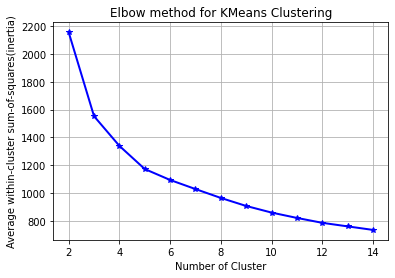

In [107]:
elbow_graph_for_k(nongk_rescaled)

In [108]:
number_of_clusters = 7
kmeanModel = KMeans(n_clusters = number_of_clusters ) 
kmeanModel.fit(nongk_rescaled)

KMeans(n_clusters=7)

In [70]:
# nongk_rescaled['Name']=non_gk['Name']
# nongk_rescaled['Overall']=non_gk['Overall']
# nongk_rescaled['BestPosition']=non_gk['BestPosition']
# nongk_rescaled.insert(0,'Name',non_gk['Name'])
# nongk_rescaled.insert(1,'Club',non_gk['Club'])
# nongk_rescaled['Cluster']=kmeanModel.labels_

In [109]:
labels=kmeanModel.labels_

In [110]:
nongk_clustered = nongk_rescaled
# nongk_clustered['Cluster']=labels
nongk_clustered['Name']=non_gk['Name'].reset_index(drop=True)
nongk_clustered['BestPosition']=non_gk['BestPosition'].reset_index(drop=True)

# nongk_clustered.insert(1,'BestPosition',non_gk['BestPosition']).reset_index(drop=True)
# nongk_clustered.insert(2,'Cluster',labels).reset_index(drop=True)


In [113]:
nongk_clustered['Cluster']=labels
nongk_clustered[nongk_clustered['BestPosition'].isnull()]

,pass_index,shoot_index,pace_index,skill_index,movement_index,defense_index,pysical_index,Name,BestPosition,Cluster


In [117]:
# kmeans clustering의 문제점: 선수 능력치가 낮은 애들은 그냥 선수특성이고 나발이고 낮은 능력치 애들로 clustering됨

def show_cluster_samples(df, cluster_no, number_of_samples):
    return  df[df['Cluster'] == cluster_no][:number_of_samples]
for cluster_no in range(number_of_clusters):
    display(show_cluster_samples(nongk_clustered, cluster_no, 50))

,pass_index,shoot_index,pace_index,skill_index,movement_index,defense_index,pysical_index,Name,BestPosition,Cluster
2232,0.34,0.71,0.52,0.62,0.60,0.11,0.45,Dagoberto Esteiro,ST,0
3395,0.39,0.67,0.38,0.60,0.54,0.20,0.61,Z. Gano,ST,0
3406,0.48,0.78,0.07,0.65,0.50,0.26,0.32,R. Santa Cruz,ST,0
3567,0.50,0.66,0.57,0.59,0.58,0.14,0.39,A. Jeremejeff,ST,0
3579,0.32,0.65,0.34,0.60,0.55,0.19,0.61,L. Pfeiffer,ST,0
3628,0.38,0.67,0.44,0.62,0.51,0.08,0.65,Sergio Castel,ST,0
3657,0.30,0.61,0.57,0.59,0.45,0.03,0.64,D. Dike,ST,0
3869,0.37,0.65,0.82,0.68,0.64,0.04,0.31,V. Supriaha,ST,0
3992,0.28,0.70,0.43,0.51,0.67,0.15,0.49,Simy,ST,0
4001,0.37,0.60,0.43,0.64,0.53,0.09,0.65,L. Palacios,ST,0


,pass_index,shoot_index,pace_index,skill_index,movement_index,defense_index,pysical_index,Name,BestPosition,Cluster
3,1.00,0.98,0.67,0.92,0.88,0.66,0.72,K. De Bruyne,CM,1
5,0.82,0.96,0.90,0.92,0.98,0.42,0.75,M. Salah,RW,1
7,0.69,0.61,0.75,0.70,0.65,1.00,0.88,V. van Dijk,CB,1
8,0.83,1.00,0.58,0.85,0.89,0.39,0.88,H. Kane,ST,1
11,0.75,0.74,0.51,0.69,0.73,0.97,0.95,Casemiro,CDM,1
13,0.90,0.75,0.59,0.85,0.86,0.91,0.90,J. Kimmich,CDM,1
14,0.69,0.60,0.64,0.79,0.81,1.00,0.88,N. Kanté,CDM,1
17,0.84,0.85,0.72,0.96,0.93,0.63,0.66,Bernardo Silva,CAM,1
18,0.86,0.76,0.83,0.89,0.83,0.90,0.78,João Cancelo,LB,1
19,0.67,0.49,0.74,0.72,0.75,0.99,0.90,Marquinhos,CB,1


,pass_index,shoot_index,pace_index,skill_index,movement_index,defense_index,pysical_index,Name,BestPosition,Cluster
1048,0.36,0.09,0.30,0.44,0.36,0.83,0.77,J. Bednarek,CB,2
1170,0.36,0.20,0.33,0.43,0.29,0.84,0.50,David Carmo,CB,2
1220,0.33,0.10,0.26,0.47,0.29,0.82,0.75,A. Hegazi,CB,2
1261,0.29,0.23,0.18,0.42,0.33,0.81,0.70,J. Lascelles,CB,2
1294,0.22,0.18,0.28,0.44,0.30,0.81,0.53,Rodrigo Ely,CB,2
1352,0.29,0.14,0.43,0.38,0.37,0.84,0.70,N. Pérez,CB,2
1672,0.29,0.14,0.43,0.38,0.37,0.84,0.70,N. Pérez,CB,2
1725,0.31,0.20,0.36,0.36,0.33,0.82,0.72,G. Hanley,CB,2
1962,0.31,0.32,0.22,0.31,0.39,0.80,0.64,E. Bičakčić,CB,2
1992,0.34,0.31,0.36,0.13,0.22,0.79,0.68,T. Šunjić,CB,2


,pass_index,shoot_index,pace_index,skill_index,movement_index,defense_index,pysical_index,Name,BestPosition,Cluster
15,0.57,0.35,0.49,0.65,0.58,0.97,0.89,Rúben Dias,CB,3
51,0.56,0.42,0.61,0.53,0.46,0.94,0.72,N. Süle,CB,3
87,0.43,0.24,0.52,0.48,0.49,0.96,0.81,S. Savić,CB,3
92,0.54,0.37,0.57,0.65,0.55,0.96,0.80,S. de Vrij,CB,3
93,0.54,0.47,0.46,0.72,0.58,0.95,0.73,J. Matip,CB,3
102,0.46,0.49,0.54,0.47,0.47,0.95,0.83,G. Chiellini,CB,3
147,0.41,0.42,0.66,0.57,0.59,0.93,0.88,C. Romero,CB,3
156,0.46,0.38,0.62,0.52,0.42,0.94,0.85,J. Giménez,CB,3
180,0.43,0.29,0.55,0.56,0.42,0.90,0.75,J. Tah,CB,3
181,0.55,0.22,0.57,0.68,0.52,0.93,0.74,A. Christensen,CB,3


,pass_index,shoot_index,pace_index,skill_index,movement_index,defense_index,pysical_index,Name,BestPosition,Cluster
0,0.99,0.98,0.78,0.99,1.00,0.24,0.65,L. Messi,CAM,4
1,0.84,0.95,0.75,0.92,0.92,0.25,0.84,K. Benzema,CF,4
2,0.80,0.99,0.69,0.90,0.92,0.32,0.95,R. Lewandowski,ST,4
4,0.79,0.94,1.00,0.97,0.98,0.27,0.80,K. Mbappé,ST,4
6,0.80,1.00,0.77,0.89,0.95,0.21,0.84,Cristiano Ronaldo,ST,4
9,0.91,0.94,0.86,1.00,0.95,0.28,0.61,Neymar Jr,LW,4
10,0.83,0.94,0.86,0.88,0.93,0.34,0.66,H. Son,LW,4
12,0.77,0.86,0.91,0.90,0.94,0.36,0.91,S. Mané,LM,4
16,0.56,0.96,0.87,0.80,0.86,0.40,0.89,E. Haaland,ST,4
33,0.59,0.92,0.83,0.80,0.82,0.30,0.85,C. Immobile,ST,4


,pass_index,shoot_index,pace_index,skill_index,movement_index,defense_index,pysical_index,Name,BestPosition,Cluster
253,0.42,0.24,0.71,0.63,0.48,0.89,0.74,I. Konaté,CB,5
317,0.34,0.16,0.50,0.55,0.32,0.90,0.77,R. Le Normand,CB,5
444,0.30,0.13,0.60,0.45,0.29,0.86,0.76,Unai Núñez,CB,5
454,0.40,0.23,0.75,0.54,0.52,0.86,0.83,Kim Min Jae,CB,5
478,0.26,0.24,0.79,0.47,0.51,0.90,0.76,Ibañez,CB,5
587,0.49,0.23,0.64,0.66,0.44,0.88,0.65,Luiz Felipe,CB,5
709,0.44,0.17,0.59,0.53,0.50,0.87,0.72,P. Lienhart,CB,5
738,0.27,0.15,0.67,0.35,0.37,0.82,0.92,J. Aidoo,CB,5
901,0.27,0.37,0.64,0.49,0.42,0.87,0.75,M. Demiral,CB,5
908,0.32,0.30,0.59,0.46,0.37,0.85,0.70,M. Salisu,CB,5


,pass_index,shoot_index,pace_index,skill_index,movement_index,defense_index,pysical_index,Name,BestPosition,Cluster
29,0.43,0.26,0.77,0.67,0.50,0.97,0.76,K. Koulibaly,CB,6
47,0.42,0.35,0.72,0.65,0.53,0.97,0.87,M. Škriniar,CB,6
125,0.48,0.30,0.83,0.57,0.60,0.94,0.87,F. Tomori,CB,6
150,0.55,0.35,0.65,0.68,0.55,0.92,0.80,Pau Torres,CB,6
152,0.55,0.41,0.70,0.53,0.58,0.91,0.85,R. Araujo,CB,6
158,0.39,0.40,0.72,0.57,0.61,0.92,0.84,Bremer,CB,6
210,0.43,0.41,0.72,0.56,0.58,0.93,0.79,Josué Chiamulera,CB,6
280,0.48,0.31,0.78,0.63,0.52,0.88,0.85,D. Upamecano,CB,6
300,0.50,0.43,0.70,0.51,0.55,0.89,0.88,Pepe,CB,6
303,0.54,0.20,0.75,0.66,0.57,0.90,0.75,J. Gomez,CB,6
